# Outline

In this notebook, we will show how to build an RPG algorithm and use it to train against different algorithms. The notebook is organized as follows:

1. Defining adversarial diversity (AD) - RPG using our package.
2. Using AD-RPG to train diverse policies in a matrix game.
4. Using AD-RPG to find diverse policies in STORM.
5. Using AD-RPG to train robust policies in Overcooked.
6. An interactive demo where you can teamup with and test the robustness of our policies in Overcooked.


### Imports

In [1]:
import os
import jax.numpy as jnp
import jax
from functools import cache
from omegaconf import OmegaConf
import wandb
import pickle
from huggingface_hub import snapshot_download
import orbax.checkpoint as ocp

from rational_policy_optimization.rpg import make_train

2025-11-07 16:19:49.303781: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:

# Set the following flag to True to retrain policies from scratch; False loads pretrained policies.
# Training with a GPU take about 10 sec for the matrix game, 30 min for STORM, and 10 hours for Overcooked.
RETRAIN_POLICIES=False #@param {type:"boolean", default:False}


## Defining adversarial diversity - RPG

In [3]:
from rational_policy_optimization.utils import RPO_Edge

N = 2 # number of base agents / manipulators
OFF_DIAG_FACTOR = 1 # balances the off-diagonal terms in the adversarial diversity loss
PARTNERPLAY_RATIO = 0.0 # partner-play regularization (between 0.00 - 0.25 is typical)

# define base and manipulator agents
base_agents = {f"base_{i}": None for i in range(N)}
manipulator_agents = {f"manipulator_{i}": None for i in range(N)}

# define objectives for the manipulator agents identical to the traditional adversarial diversity algorithm
# starting with the manipulators wanting to maximize base agents self-play 
manipulator_max = [
    RPO_Edge(
        id=f"manipulator_{i}",
        source=f"base_{i}",
        target=f"base_{i}",
        weight=1.0,
        source_player_idx=(0,1),
        shaped_base=f"base_{i}",
    )
    for i in range(N)
]

# and minimize base agent cross-play
manipulator_min = [
    RPO_Edge(
        id=f"manipulator_{i}",
        source=f"base_{i}",
        target=f"base_{j}",
        weight=-1.0 * OFF_DIAG_FACTOR / (N - 1),
        source_player_idx=(0,1),
        shaped_base=f"base_{i}",
    )
    for i in range(N)
    for j in range(N)
    if i != j
]

# define objectives for the base agents
# starting with maximizing reward against their manipulator
base_selfplay = [
    RPO_Edge(
        id=f"base_{i}",
        source=f"base_{i}",
        target=f"manipulator_{i}",
        weight=1.0 - N * PARTNERPLAY_RATIO,
        source_player_idx=(0, 1),
    )
    for i in range(N)
]

# then adding in partner-play regularization against all base agents
base_crossplay = [
    RPO_Edge(
        id=f"base_{i}",
        source=f"base_{i}",
        target=f"base_{j}",
        weight=PARTNERPLAY_RATIO,
        source_player_idx=(0, 1),
    )
    for i in range(N)
    for j in range(N)
]
base_objective = base_selfplay + base_crossplay

manipulator_objective = manipulator_max + manipulator_min

rpg_config = (base_agents, manipulator_agents, base_objective, manipulator_objective)

## Using adversarial training RPG in matrix games

In [ ]:
config = OmegaConf.load("data/configs/rpg_matrix.yaml")
config = OmegaConf.to_container(config)


payoff_matrix = jnp.array(
    [
        [[  1,   1], [ 0,  0]], 
        [[0.9, 0.9], [-1, -1]], 
        [[  0,   0], [ 1,  1]]
    ]
)
config["ENV_KWARGS"]["payoffs"] = payoff_matrix

wandb.init(
    mode="disabled",
)

if RETRAIN_POLICIES:
    print("This should take about 20 seconds to compile and train. Set RETRAIN_POLICIES=False to use a pretrained policy instead.")
    train = make_train(config, rpg_config)
    rng = jax.random.PRNGKey(0)
    outs = train(rng)
    jax.block_until_ready(outs)
else:
    local_root = snapshot_download(
        repo_id="nlauffer/rpg-demo",
        revision="main",
        allow_patterns=["orbax_models/**"],  # only grab the checkpoints
    )
    ckpt_dir = os.path.join(local_root, "orbax_models", "rpg_matrix")
    checkpointer = ocp.PyTreeCheckpointer()
    outs = checkpointer.restore(ckpt_dir)

params = outs["runner_state"][0]
matrix_metrics = outs["metrics"]


This will take 20 seconds to train. Set RETRAIN_POLICIES=False to use a pretrained policy instead.


### Extract and print the learned policies

In [6]:
# Visualize the trained policies
from rational_policy_optimization.utils import get_matrix_policy

# Get policy distributions for all agents
print("Payoff matrix:")
print(payoff_matrix[:,:,0])
print("Learned policies:")
for agent_name in ["manipulator_0", "base_0", "manipulator_1", "base_1"]:
    if "base" in agent_name:   
        policy = get_matrix_policy(config, params["actor"]["base"][agent_name], agent_idx=0)
        probs = policy.probs[0]
    else:
        policy = get_matrix_policy(config, params["actor"]["manipulator"][agent_name], agent_idx=1)
        probs = policy.probs[0]
        # combine action 0 and 2 into a single action (because of how the environment handles variable sized actions spaces)
        probs = jnp.array([probs[0] + probs[2], probs[1]])
    prob_str = ", ".join(f"{p:.3f}" for p in probs)
    print(f"{agent_name} [{prob_str}]")
    

Payoff matrix:
[[ 1.   0. ]
 [ 0.9 -1. ]
 [ 0.   1. ]]
Learned policies:
manipulator_0 [1.000, 0.000]
base_0 [0.978, 0.013, 0.008]
manipulator_1 [0.000, 1.000]
base_1 [0.011, 0.002, 0.987]


## STORM Gridworld Environment

In [14]:
config = OmegaConf.load("data/configs/rpg_storm.yaml")
config = OmegaConf.to_container(config)

rng = jax.random.PRNGKey(0)
payoff_matrix = jnp.array(
    [
        [[1, 1], [0, 0]], 
        [[0, 0], [1, 1]], 
    ]
)
config["ENV_KWARGS"]["payoff_matrix"] = payoff_matrix

wandb.init(
    mode="disabled",
)

if RETRAIN_POLICIES:
    print("This will take 30 minutes to train. Set RETRAIN_POLICIES=False to use a pretrained policy instead.")
    train = make_train(config, rpg_config)
    rng = jax.random.PRNGKey(0)
    outs = train(rng)
    jax.block_until_ready(outs)
else:
    local_root = snapshot_download(
        repo_id="nlauffer/rpg-demo",
        revision="main",
        allow_patterns=["orbax_models/**"],  # only grab the checkpoints
    )
    ckpt_dir = os.path.join(local_root, "orbax_models", "rpg_storm")
    checkpointer = ocp.PyTreeCheckpointer()
    outs = checkpointer.restore(ckpt_dir)

jax.block_until_ready(outs)

storm_params = outs["runner_state"][0]
storm_metrics = outs["metrics"]


Fetching 73 files:   0%|          | 0/73 [00:00<?, ?it/s]

/nas/ucb/nlauffer/carrot-horse/.venv/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


### Plot STORM training curves

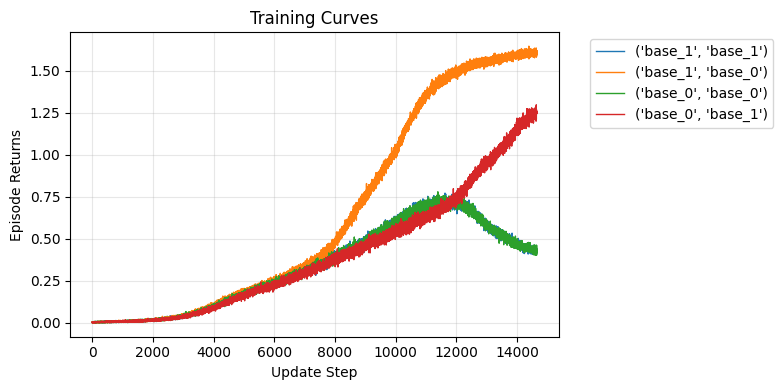

In [17]:
### Define plotting function for training curves
import matplotlib.pyplot as plt
from rational_policy_optimization.utils import create_rpg_graph

rpg_graph = create_rpg_graph(*rpg_config)

# Extract data dimensions
num_updates = storm_metrics["base"]["info"]["returned_episode_returns"].shape[0]

plt.figure(figsize=(8, 4)) 

# Base agent returns
base_returns = storm_metrics["manipulator"]["info"]["returned_episode_returns"]
for i, name in enumerate(rpg_graph.manipulator_rollouts):
    mean_returns = base_returns[:, i]  # Average over environments    
    plt.plot(mean_returns, label=f"{name}", linewidth=1)

plt.xlabel("Update Step")
plt.ylabel("Episode Returns")
plt.title("Training Curves")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Rollout a cross play grid between the pair of learned policies

In [18]:
from IPython.display import HTML
from rational_policy_optimization.utils import visualize
import os

os.makedirs("storm_viz", exist_ok=True)
visualize(config, rpg_graph, storm_params, rng, save_path="storm_viz")

HTML("""
<style>
.row {
  display: flex;
  justify-content: center;
  gap: 10px;
  margin-bottom: 6px;
}
.top-half {
  width: 250px;                 /* visible width */
  clip-path: inset(0 0 47% 0);  /* crop bottom 53% */
  display: block;
}
/* shift the second row upward */
.row.shift-up {
  margin-top: -215px;  /* adjust this number for how far upward you want */
}
</style>

<div class="row">
  <img class="top-half" src="storm_viz/base_0-vs-base_0.gif">
  <img class="top-half" src="storm_viz/base_0-vs-base_1.gif">
</div>
<div class="row shift-up">
  <img class="top-half" src="storm_viz/base_1-vs-base_0.gif">
  <img class="top-half" src="storm_viz/base_1-vs-base_1.gif">
</div>
""")


# Interactive Overcooked Demo

In [ ]:
from rational_policy_optimization.rpg_algs import make_rpg_alg

config = OmegaConf.load("data/configs/rpg_overcooked.yaml")
config = OmegaConf.to_container(config)

wandb.init(
    mode="disabled",
)

# get a version of AD-RPG with different hyperparameters
rpg_config = make_rpg_alg(config)

if RETRAIN_POLICIES:
    print("This will take ~10 hours to train. Set RETRAIN_POLICIES=False to use a pretrained policy instead.")
    train = make_train(config, rpg_config)
    rng = jax.random.PRNGKey(0)
    outs = train(rng)
    jax.block_until_ready(outs)
else:
    local_root = snapshot_download(
        repo_id="nlauffer/rpg-demo",
        revision="main",
        allow_patterns=["orbax_models/**"],  # only grab the checkpoints
    )
    ckpt_dir = os.path.join(local_root, "orbax_models", "rpg_overcooked")
    checkpointer = ocp.PyTreeCheckpointer()
    outs = checkpointer.restore(ckpt_dir)

jax.block_until_ready(outs)
overcooked_params = outs["runner_state"][0]
metrics = outs["metrics"]


Fetching 73 files:   0%|          | 0/73 [00:00<?, ?it/s]

/nas/ucb/nlauffer/carrot-horse/.venv/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


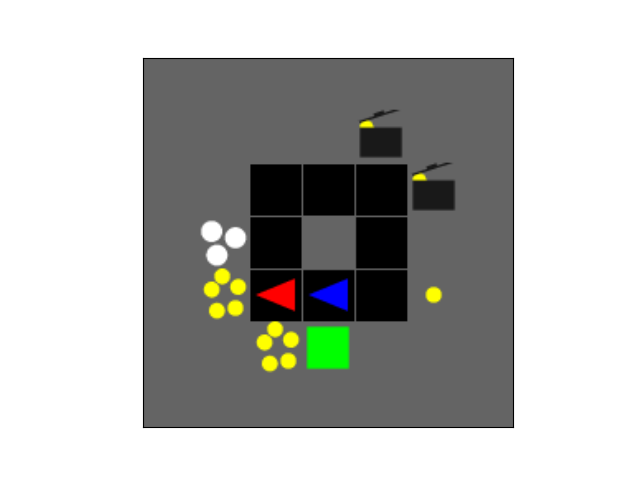

In [ ]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

from functools import partial

from rational_policy_optimization.utils import Actor
from rational_policy_optimization.wrappers import registration_wrapper
from rational_policy_optimization.extra_environments.overcooked.interactive import key_handler_overcooked

from jaxmarl.environments.overcooked.overcooked import Overcooked
from jaxmarl.environments.overcooked.layouts import overcooked_layouts as layouts
from jaxmarl.viz.overcooked_visualizer import OvercookedVisualizer as Visualizer


class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

layout_name = 'coord_ring'
actor_params = overcooked_params["actor"]['base']["horse_0"]

args = {
    "env": "Overcooked",
    "layout": layout_name,
    "random_reset": False,
    "seed": 0,
    "render_agent_view": False,
    "debug": False
}

args = dotdict(args)
layout = layouts[args.layout]
env = Overcooked(
    layout=layout,
    random_reset=args.random_reset
)

viz = Visualizer()
obs_viz = None
obs_viz2 = None

# env = registration_wrapper.make("overcooked")
actor_network = Actor(env.action_space(env.agents[0]).n, activation='tanh', hidden_sizes=config["HIDDEN_SIZES"])

rng = jax.random.PRNGKey(0)

# trick to get rendering to work in ipython notebook
def key_handler_wrapper(env, extras, event):
    clear_output(wait=True) # ensure the cell shows only the next frame
    return key_handler_overcooked(env, extras, event)

print("You play as the red agent. Use the arrow keys to move and space to interact (pickup or deposit items).")

with jax.disable_jit(True):
    jit_reset = jax.jit(env.reset)
    # jit_reset = env.reset_env
    key = jax.random.PRNGKey(args.seed)
    key, subkey = jax.random.split(key)
    o0, s0 = jit_reset(subkey)
    viz.render(env.agent_view_size, s0, highlight=False)

    key, subkey = jax.random.split(key)
    extras = {
        'rng': subkey,
        'policy': actor_network,
        'params': actor_params,
        'state': s0,
        'obs': o0,
        'viz': viz,
        'obs_viz': obs_viz,
        'obs_viz2': obs_viz2,
        'jit_reset': jit_reset,
        'agent_view_size': env.agent_view_size,
        'env': args.env,
        'debug': args.debug
    }
    extras["out"] = widgets.Output()
    display(extras["out"])

    viz.window.reg_key_handler(partial(key_handler_wrapper, env, extras))